<a href="https://colab.research.google.com/github/jesvin1/Basics/blob/master/Nifty_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html

#Importing the required packages

In [2]:
#!pip install pmdarima
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=a3508f8bb9e7f8b23b89bdcb0a430f96c6df522f9287124aafe87346bb666463
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import datetime as datetime
import yfinance as yf

#Load the Data

In [0]:
# sets the sample period as 5 years back from 09/12/2019
end = datetime.datetime(2020, 4, 1)
start = end - datetime.timedelta(days = 15*365)


In [5]:
# gets the closing price fo HDFC for the past 7 years
my_stock = yf.Ticker('^NSEI')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end)['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')
my_stock.head()

,close
Date,
2007-09-17,4494.65
2007-09-18,4546.20
2007-09-19,4732.35
2007-09-20,4747.55
2007-09-21,4837.55


##Checking for Stationarity

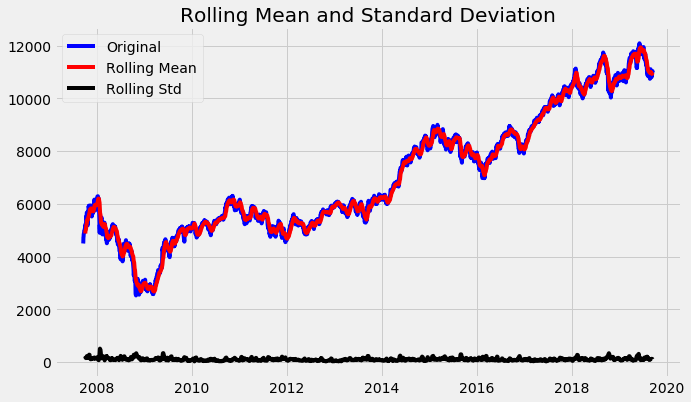

Results of dickey fuller test
Test Statistics                  -0.287236
p-value                           0.927293
No. of lags used                  7.000000
Number of observations used    2918.000000
critical value (1%)              -3.432593
critical value (5%)              -2.862531
critical value (10%)             -2.567298
dtype: float64


In [0]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(my_stock.close)

##Separate Trend and Seasonality from the time series



<Figure size 720x432 with 0 Axes>

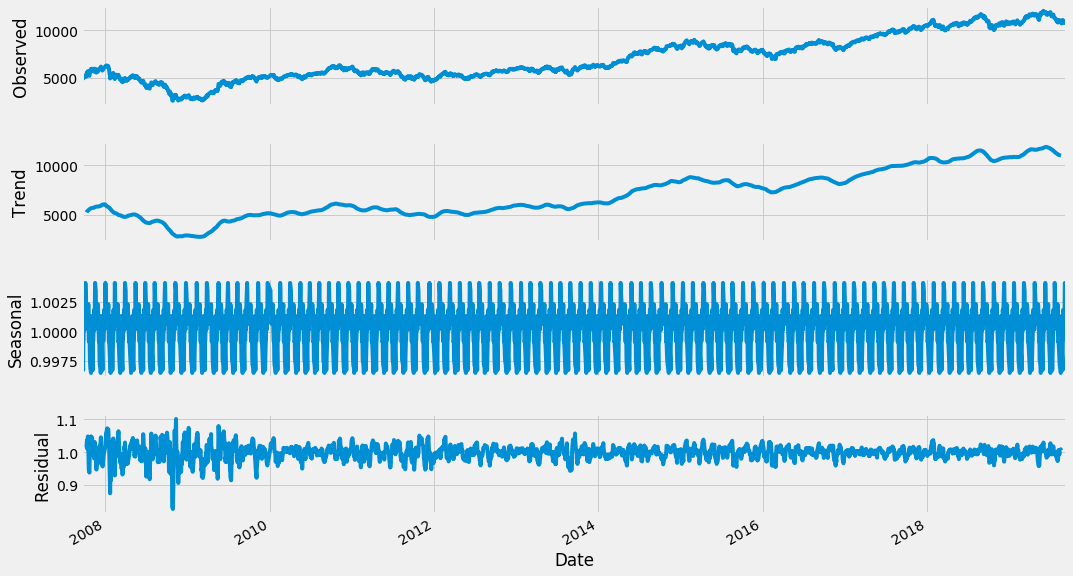

In [0]:
result = seasonal_decompose(my_stock, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


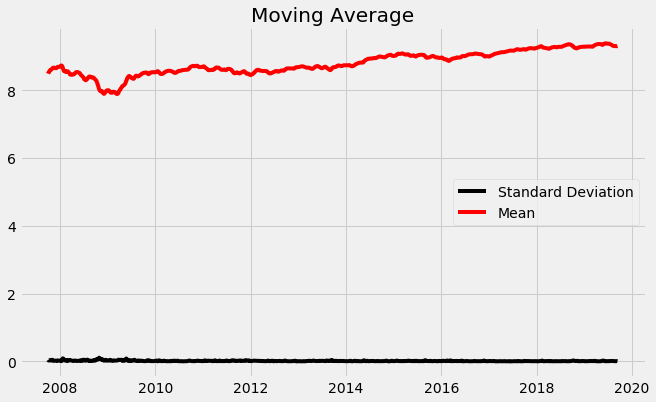

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(my_stock)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

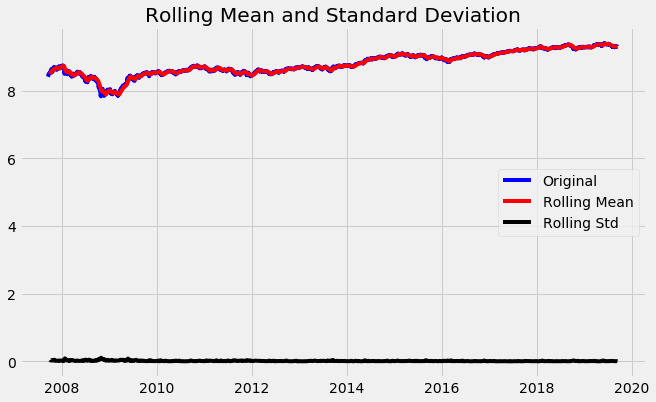

Results of dickey fuller test
Test Statistics                  -0.727837
p-value                           0.839407
No. of lags used                  7.000000
Number of observations used    2918.000000
critical value (1%)              -3.432593
critical value (5%)              -2.862531
critical value (10%)             -2.567298
dtype: float64


In [0]:
test_stationarity(df_log.close)

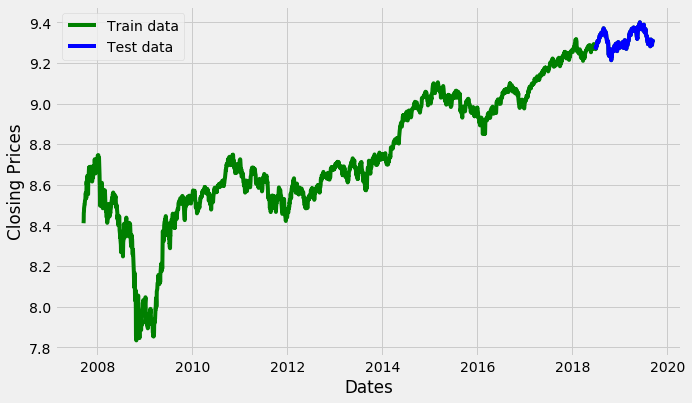

In [0]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.

In [0]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-14858.888, BIC=-14847.139, Time=0.506 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=-14872.118, BIC=-14854.495, Time=0.464 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-14872.818, BIC=-14855.195, Time=0.925 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=-14859.672, BIC=-14853.798, Time=0.169 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=-14871.221, BIC=-14847.723, Time=1.198 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-14871.600, BIC=-14848.102, Time=1.051 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=-14869.808, BIC=-14840.437, Time=2.603 seconds
Total fit time: 6.939 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 2630
Model:               SARIMAX(0, 1, 1)   Log Likelihood

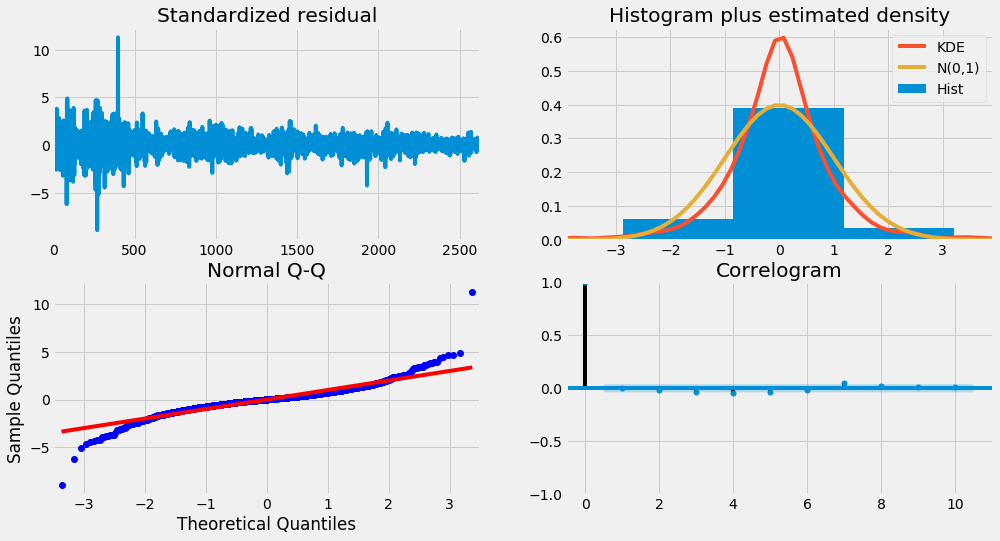

In [0]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [0]:
model = ARIMA(train_data, order=(0, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 2629
Model:                 ARIMA(0, 1, 1)   Log Likelihood                7439.420
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 24 Feb 2020   AIC                         -14872.840
Time:                        11:13:14   BIC                         -14855.217
Sample:                             1   HQIC                        -14866.458
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      1.025      0.305      -0.000       0.001
ma.L1.D.close     0.0794      0.020      4.023      0.000       0.041       0.118
                                    Root

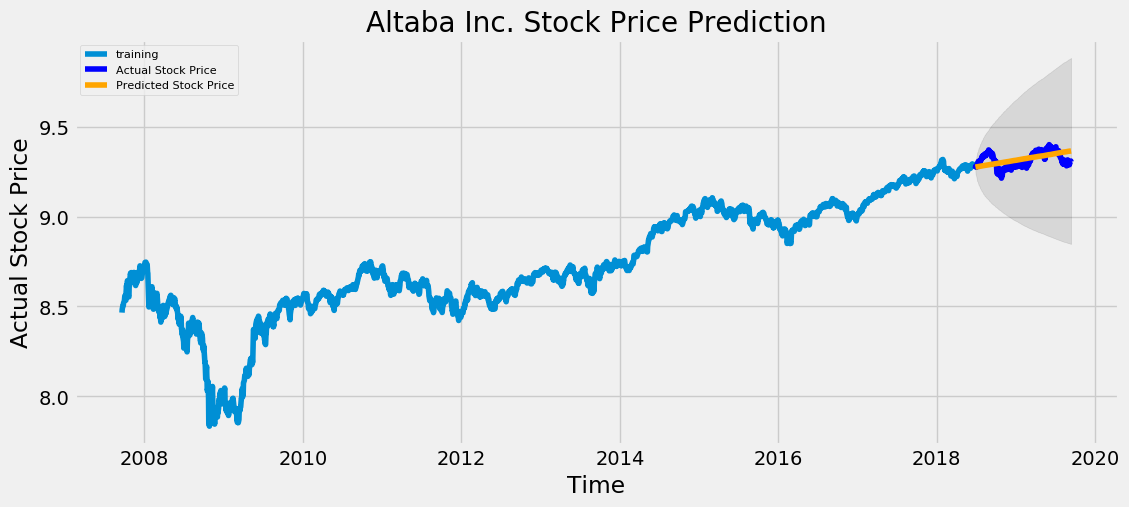

In [0]:
# Forecast
fc, se, conf = fitted.forecast(293, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [0]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.001581730296721256
MAE: 0.034833402558224515
RMSE: 0.03977097304217306


ValueError: ignored

https://towardsdatascience.com/3-time-series-models-anyone-can-build-e6943b017c41

In [6]:
my_stock.head()

,close
Date,
2007-09-17,4494.65
2007-09-18,4546.20
2007-09-19,4732.35
2007-09-20,4747.55
2007-09-21,4837.55


In [0]:

my_stock = my_stock.rename(columns = {my_stock.columns[0]:"y"})
#my_stock = my_stock.index.names['ds']
duration = 14
train = my_stock.iloc[:-duration,:].copy()
test = my_stock.iloc[-duration:,:].copy()

In [8]:
train.head()

,y
Date,
2007-09-17,4494.65
2007-09-18,4546.20
2007-09-19,4732.35
2007-09-20,4747.55
2007-09-21,4837.55


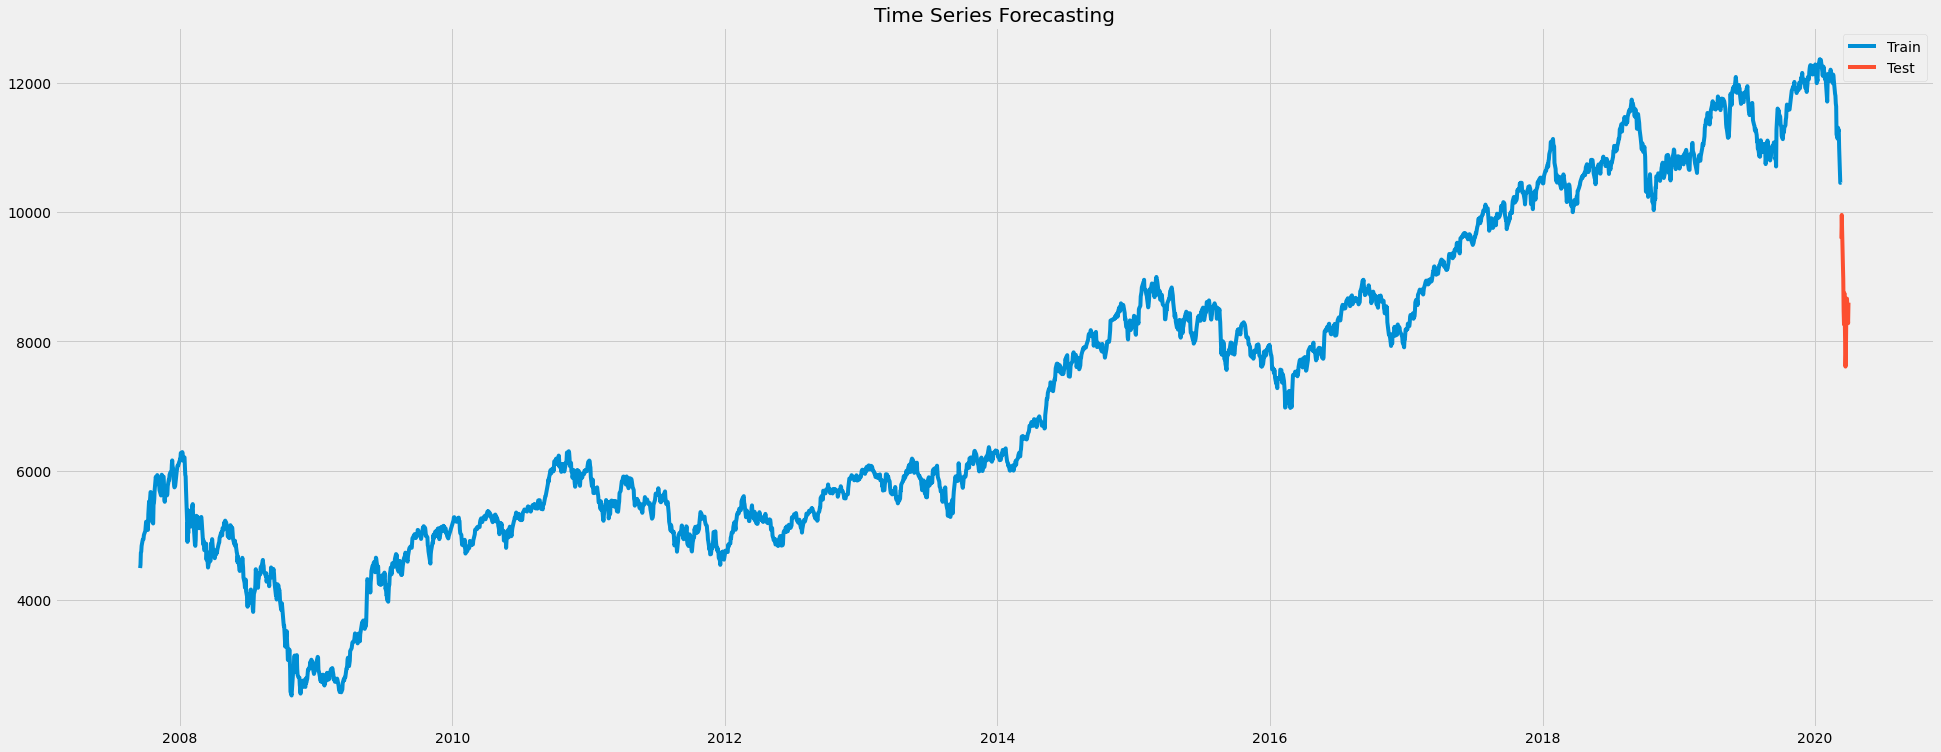

In [9]:
# Visualization
plt.figure(figsize=(30,12))
plt.plot(train["y"],label="Train")
plt.plot(test["y"],label="Test")
plt.title("Time Series Forecasting")
plt.legend()

In [10]:
## Persistence algorithm
pred= []
for i in range(duration):
    pred.append(train.iloc[-1,1])    # add test data to train
    train = train.append(test.iloc[i])

IndexError: ignored